In [2]:
import pandas as pd
from os import path

# Choose ML results directory for semi-manual analysis
#directory = "results-gtm"
#directory = "results-sgtm"
#directory = "results-iter1"
#directory = "results-sgtm-smote"
#directory = "../out-content/results"
directory = "results-iter2"

columns = ["label", "prediction", "url", "visit_id"]
df = None


# I ran 10-fold cross validation so there are 10 different files for test data predictions
for i in range(10):
    # The ML model output files use a weird separator: " |$| "
    temp_df = pd.read_table(path.join(directory, f"tp_{i}"), header=None, sep="\ \|\$\|\ ", names=columns, engine='python')

    if df is None:
        df = temp_df
    else:
        df = pd.concat([df, temp_df])


## Input labels analysis

In [35]:
df_labels = pd.read_csv("labelled-sgtm.csv")
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830553 entries, 0 to 830552
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0.1      830553 non-null  int64  
 1   Unnamed: 0        830553 non-null  int64  
 2   visit_id          830553 non-null  float64
 3   top_level_url     830553 non-null  object 
 4   name              830553 non-null  object 
 5   braveblock_label  830553 non-null  bool   
 6   label             830553 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(2)
memory usage: 33.3+ MB


## False Positives analysis
We want to check whether our model can find other server-side tracker requests (in addition to GTM)

In [2]:
# False Negatives
fn = df[df["prediction"] & ~df["label"]]

# Print entire df to file for better readability (can't get Pycharm+jupyter to display df nicely)
fn.to_csv("temp_df.csv")
fn

,label,prediction,url,visit_id
1102,False,True,https://ml314.com/utsync.ashx?pub=&adv=&et=0&e...,65860553664439
1107,False,True,https://www.google.ee/ads/ga-audiences?v=1&t=s...,65860553664439
1111,False,True,https://www.google.ee/ads/ga-audiences?v=1&t=s...,65860553664439
1112,False,True,https://googleads.g.doubleclick.net/pagead/vie...,65860553664439
1113,False,True,https://googleads.g.doubleclick.net/pagead/vie...,65860553664439
...,...,...,...,...
67583,False,True,https://ingest.quantummetric.com/horizon/lumen...,8792294440948776
67584,False,True,https://ingest.quantummetric.com/horizon/lumen...,8792294440948776
67858,False,True,https://sb.scorecardresearch.com/b?c1=2&c2=690...,8889417237623677
67859,False,True,https://sb.scorecardresearch.com/b?c1=2&c2=690...,8889417237623677


## All Server-side GTM predictions

In [7]:
def is_google(df):
    """ Check that request is not going to a google tracking domain. """

    google_domains = ['region1.google-analytics.com', 'region1.analytics.google.com', 'stats.g.doubleclick.net', 'www.google-analytics.com', 'analytics.google.com']
    values = df["url"].str.contains("|".join(google_domains), regex=True)
    return values

df_sgtm = df[df["url"].str.contains('/g/collect') & ~ is_google(df)]
#df_sgtm.to_csv("temp_df.csv")

In [4]:
df_sgtm["prediction"].value_counts()

prediction
False    162
True       2
Name: count, dtype: int64

## Aggregated statistics
The WebGraph ML model outputs

In [36]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os


# All WebGraph ML results folders should be named like "results-*" to make scripted analysis easier
result_dirs  = [ f.name for f in os.scandir(".") if f.is_dir() and f.name.startswith("results-") ]

df_dict = {}
for dirname in result_dirs:
    # Skip unfinished ML jobs
    if not os.path.isfile(os.path.join(dirname, "tp_9")):
        continue

    columns = ["label", "prediction", "url", "visit_id"]
    df = None

    # I ran 10-fold cross validation so there are 10 different files for test data predictions
    for i in range(10):
        # Memory footprint of one full df is ~150MB
        temp_df = pd.read_table(path.join(dirname, f"tp_{i}"), header=None, sep="\ \|\$\|\ ", names=columns, engine='python')
        # Memory footprint for only labels and predictions is ~6MB
        #temp_df = pd.read_table(path.join(dirname, f"tp_{i}"), header=None, sep="\ \|\$\|\ ", names=columns, engine='python', usecols=["label", "prediction"])

        if df is None:
            df = temp_df
        else:
            df = pd.concat([df, temp_df])

    df["sgtm"] = df["url"].str.contains('/g/collect') & ~ is_google(df)
    df_dict[dirname] = df.copy()

memory_footprints = [df.memory_usage(index=True,deep=True).sum() for df in df_dict.values()]
print(f"Memory use of loaded DataFrames {round(sum(memory_footprints)/1000000,2)}MB (avg {round(sum(memory_footprints)/len(memory_footprints)/1000000,2)}MB per df)")


Memory use of loaded DataFrames 1080.8MB (avg 154.4MB per df)


In [37]:
def report_to_latex(report, table_name):
    """ Parse sklearn.metrics.classification_report into a latex table.

    Code adapted from: https://gist.github.com/Lorenzoantonelli/40454798ae53386a1d5b9c8bb60664d5
    """

    if report[0] == '\n':
        report = report[1:]
    if report[-1] == '\n':
        report = report[:-1]

    lines = report.split('\n')

    header = ["\\begin{table}",
              f"\\caption{{Classification Report for {table_name}}}",
              f"\\label{{table:classification:{table_name}}}",
              "\\centering",
              "\\begin{tabular}{r r r r r}",
              "& Precision & Recall & F-score & Support",
              "\\\\"]

    body = []
    for line in lines[2:-4]:
        row = line.split()
        if len(row) == 5:
            body.append(" & ".join(row) + "\\\\")

    body.append("\\\\")

    footer = []
    for line in lines[-3:]:
        row = line.split()
        if len(row) == 3:
            footer.append("{} & & & {} & {}\\\\".format(*row))
        elif len(row) == 6:
            footer.append("{} {} & {} & {} & {} & {}\\\\".format(*row))

    footer.extend(["\\end{tabular}", "\\end{table}"])

    latex_table = '\n'.join(header + body + footer)

    return latex_table


for dirname, df in df_dict.items():
    print("#######################################################################################################################################")
    print(dirname)
    results = classification_report(y_true=df["label"].to_numpy(), y_pred=df["prediction"].to_numpy())

    # Uncomment either of the following lines to get results as nicely formated string or latex
    #print(results)
    print(report_to_latex(results, dirname))

#######################################################################################################################################
results-sgtm-smote
\begin{table}
\caption{Classification Report for results-sgtm-smote}
\label{table:classification:results-sgtm-smote}
\centering
\begin{tabular}{r r r r r}
& Precision & Recall & F-score & Support
\\
False & 1.00 & 1.00 & 1.00 & 678328\\
True & 0.52 & 0.16 & 0.24 & 164\\
\\
accuracy & & & 1.00 & 678492\\
macro avg & 0.76 & 0.58 & 0.62 & 678492\\
weighted avg & 1.00 & 1.00 & 1.00 & 678492\\
\end{tabular}
\end{table}
#######################################################################################################################################
results-sgtm-downsample
\begin{table}
\caption{Classification Report for results-sgtm-downsample}
\label{table:classification:results-sgtm-downsample}
\centering
\begin{tabular}{r r r r r}
& Precision & Recall & F-score & Support
\\
False & 1.00 & 0.18 & 0.31 & 678340\\
True & 0.00 & 0.98 &

## Adblocking performance: GTM vs SGTM
We want to assess the performance of EasyList and WebGraph on detecting GTM and SGTM requests

In [18]:
df_labels = pd.read_csv("labelled.csv")
df_labels.rename(columns={"name": "url"}, inplace=True)
df_labels["sgtm"] = df_labels["url"].str.contains('/g/collect') & ~ is_google(df_labels)
df_labels["regular_gtm"] = df_labels["url"].str.contains('/g/collect') & is_google(df_labels)

In [34]:
total_gtm = len(df_labels[df_labels["regular_gtm"] & df_labels["label"]])
total_sgtm = len(df_labels[df_labels["sgtm"] & df_labels["label"]])

detected_gtm_brave = len(df_labels[df_labels["regular_gtm"] & df_labels["label"] & df_labels["braveblock_label"]])
detected_sgtm_brave = len(df_labels[df_labels["sgtm"] & df_labels["label"] & df_labels["braveblock_label"]])

gtm_brave_percentage = round(detected_gtm_brave / total_gtm * 100, 2)
sgtm_brave_percentage = round(detected_sgtm_brave / total_sgtm * 100, 2)

print(total_sgtm, total_gtm, detected_sgtm_brave, detected_gtm_brave)

203 6813 10 6813


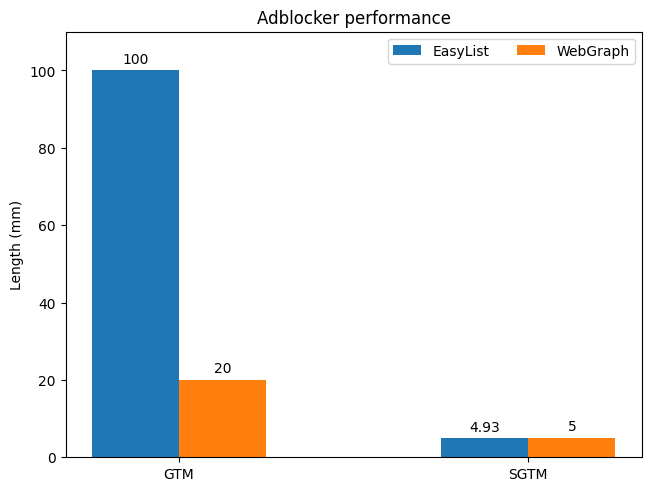

In [48]:
import matplotlib.pyplot as plt
import numpy as np

species = ("GTM", "SGTM")
penguin_means = {
    'EasyList': (gtm_brave_percentage, sgtm_brave_percentage),
    'WebGraph': (20, 5),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Detection percentage')
ax.set_title('Adblocker performance')
ax.set_xticks(x + width/2, species)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 110)

plt.show()